# Question 1

Generate 5000 synthetic data points (x, y) as follows:
- Using the rnorm() function in R (or equivalent in Matlab or Python or etc), create a vector, x, containing 5000 observations drawn from a Gaussian distribution N(0, 1) [ie, a normal distribution with mean 0 and variance 1]. This vector x represents your set of inputs x.
- Using the rnorm() function in R (or equivalent in Matlab or Python or etc), create a vector, eps, containing 5000 observation drawn from a N(0, 0.25) distribution; ie, a normal distribution with mean 0 and variance 0.25. 
- Using vectors x and eps, generate a vector y according to the model $y = -1 + 0.5x – 2x^2 + 0.3x^3 + eps.$


Your 5000 data-points (x, y) are generated upon completion of this Part-c. Note that the true function is a cubic function with true weight vector being w_true = (-1, +0.5, -2, +0.3). 
- Implement the Adaline and Sigmoid neuron learning algorithms using (i) batch gradient descent [BGD] and (ii) stochastic gradient descent [SGD]. Using a cross-validation method of your choice (LOOCV or 10-fold-cv), test and compare their regression performances over the synthetic dataset created above. The initializations, the learning rate, the size of test set and training set, and the stopping criterion, and etc are left for you to explore. Think about the reasons why you use a particular strategy. Use your creativity and perform wha

# 1.1. Synthesis data generation

We use `normal` in `numpy` which takes the mean and standard deviation ($=\sqrt{Variance}$) to create x (mean=0, variance=1), eps (mean=0, variance=0.25), and y. 

In [1]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt

np.random.seed(0)
x = np.random.normal(0, 1, 5000)
eps = np.random.normal(0, np.sqrt(0.25), 5000)
y = -1 + 0.5*x - 2*x**2 + 0.3*x**3 + eps

The following figures are the plots of $y$ and histograms of $x$ and $eps$

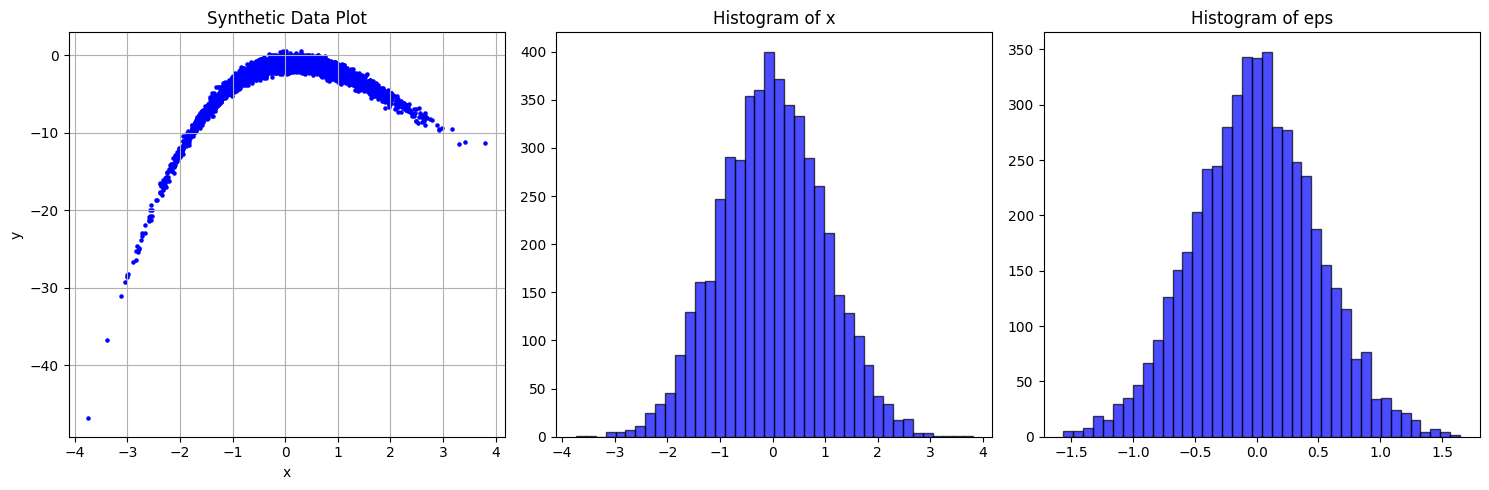

In [2]:
# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot of synthetic data
axs[0].scatter(x, y, s=5, color='blue', label='Synthetic Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Synthetic Data Plot')
axs[0].grid(True)


axs[1].hist(x, bins=40, density=False, color='blue', edgecolor='black', alpha=0.7)
axs[1].set_title('Histogram of x')

# Plot for eps
axs[2].hist(eps, bins=40, density=False, color='blue', edgecolor='black', alpha=0.7)
axs[2].set_title('Histogram of eps')
plt.tight_layout()
plt.show()


We conducted the experiment by splitting the data into training and test set:
- The size of the test set we selected is 25%. 
- The remaining 75% of data will be used for training on which we applied 10-fold cross validation to find an appropriate learning rate.

In [3]:
X = np.array([np.ones_like(x), x]).T
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
kf = KFold(n_splits=10, shuffle=True, random_state=0)

### 1.2 Cross validation
On training set, we used 10-fold validation to search for the learning rate $\eta$ in range $[10^{-3}; 10^{-10}]$. The following function will return the learning rate with smallest average MSE across 10 folds.


In [4]:
def calc_mse(y_hat, y): 
    return np.mean((np.array(y) - np.array(y_hat)) ** 2)

def train_neuron(algo, algo_predict_func):
    learning_rates = [10**(-i) for i in range(3, 11)]

    avg_mse_scores = [] # store the average of MSE on test fold of each learning rate
    
    for eta in learning_rates:
        mse_scores = [] # store MSE on test folds
        for train_fold, test_fold in kf.split(x_train):
            w, _ = algo(x_train[train_fold], y_train[train_fold], eta, max_epoch=100)

            y_hat = [algo_predict_func(x_i, w) for x_i in x_train[test_fold]]

            mse_scores.append(calc_mse(y_hat, y_train[test_fold]))
        
        avg_mse_scores.append(np.mean(mse_scores))
        print(f"eta= {eta}, average MSE: {np.mean(mse_scores)}")
    print('Best learning rate: ', learning_rates[np.argmin(avg_mse_scores)])
    return learning_rates[np.argmin(avg_mse_scores)]

def ploting_results(mse_scores, x_test, y_test, y_hat_test):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(mse_scores)), mse_scores, color='red')
    plt.title("MSE of epochs on training set")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")

    plt.subplot(1, 2, 2)  # 2 rows, 1 column, subplot 2
    plt.scatter(x_test[:,1], y_hat_test, color='red', label="y_hat", s=2)
    plt.scatter(x_test[:,1], y_test, color='blue', label="y", s=2)
    plt.title("Prediction on test set")
    plt.xlabel("x_test")
    plt.ylabel("y")
    plt.legend()

    plt.tight_layout()
    plt.show()

## 1.2 Neuro Learning Algorithms
For learning algorithms, we implemented Adaline, Sigmoid in SGD or BGD mode with:
- Initialization: We initialize the weights with random values in $[-0.5, 0.5]$
- Stopping criterion: Stop when reach maximum iteration, we defined a max epoch so that the algorithm will terminate after it reach the maximum iteration. By using max epoch, we can make sure that the algorithm can eventually terminates (max epoche). It can also be terminated if the performance can not be improved.

### 1.2.1 Adaline Neuron Algorithm
- The `adaline_bgd` function is implemented based on the code of the batch mode of Adaline Neuron Algorithm in lecture slide.
- The `adaline_sgd` function is implemented based on the code of the stochastic mode of Adaline Neuron Algorithm in lecture slide.
- The `adaline_predict` function return the prediction of the Adaline Neuron using the formula $\hat{y} = \phi(v) = v$ where $v = w^{T}x$

In [5]:
np.random.seed(0)

def adaline_predict(x, w):
    v = w.T.dot(x)
    return v

def adaline_bgd(X, y, eta=0.005, max_epoch=100):
    """
    Adaline Batch gradient descent
    Return 
    - w: learned w
    - mse_scores: mse of every epoch
    """
    
    w = np.random.random(X.shape[1]) * -1 + 0.5 # weights initialization in range [-0.5, 0.5]
    mse_scores = []
    for _ in range(max_epoch):
        d_w = np.zeros(X.shape[1])
        for x_i, y_i in zip(X, y):
            y_hat_i = w.T.dot(x_i)
            d_w += eta * (y_i - y_hat_i) * x_i # accumulate the gradient for all samples
            
        w = w + d_w
        mse_scores.append(calc_mse([adaline_predict(x_i, w) for x_i in X], y))
    return w, mse_scores

def adaline_sgd(X, y, eta=0.005, max_epoch=100):
    """
    Adaline Sochastic gradient descent
    Return 
    - w: learned w
    - mse_scores: mse of every epoch
    """
    
    w = np.random.random(X.shape[1]) * -1 + 0.5 # weights initialization in range
    mse_scores = []
    for _ in range(max_epoch):
        for x_i, y_i in zip(X, y): # iteration through all sample 
            y_hat_i = w.T.dot(x_i) # predict output
            w += eta * (y_i - y_hat_i) * x_i # calculate the gradient of one sample and update the weights
        
        mse_scores.append(calc_mse([adaline_predict(x_i, w) for x_i in X], y))
    return w, mse_scores

#### Adaline - Batch mode

By using cross validation, we found that the learning rate of 0.0001 resulted in lowest average MSE across 10 folds. So we selected this learning rate and plot the learning curve on training set, we observed that the MSE is getting lower through epoch. After 100 epochs, the weight of the neuron is $w=[-2.9677, 1.3948]$. 

On the test data, the MSE is 7.1359. We plotted the prediction (red points) and observed that the function that Adaline learned is linear function because the activation is an identity function.

Training:
eta= 0.001, average MSE: 2.498173164354817e+77
eta= 0.0001, average MSE: 8.368506544565822
eta= 1e-05, average MSE: 8.379131492741546
eta= 1e-06, average MSE: 13.174896591412127
eta= 1e-07, average MSE: 18.879408265853726
eta= 1e-08, average MSE: 18.962724667587587
eta= 1e-09, average MSE: 18.89721689733735
eta= 1e-10, average MSE: 20.338257248786228
Best learning rate:  0.0001
w:  [-2.96767264  1.39484566]
MSE on test data: 7.135853452396288


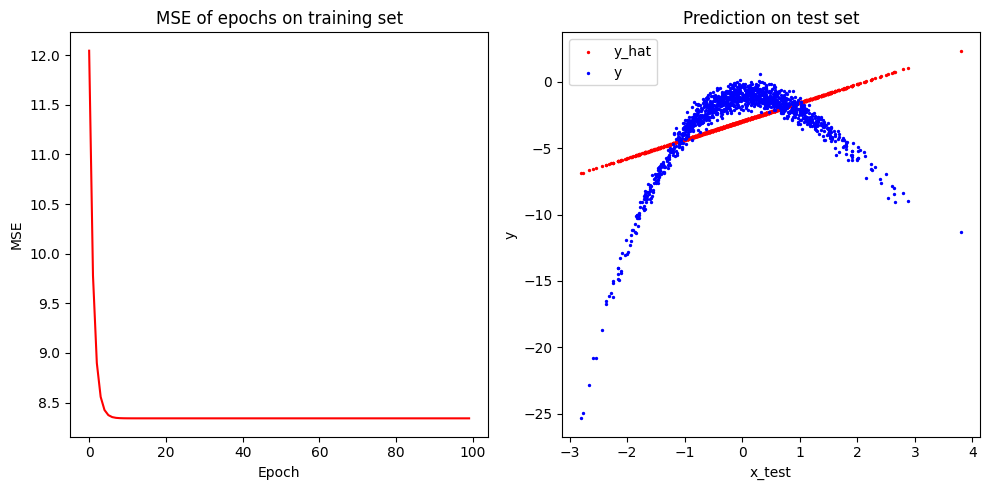

In [6]:
print("Training:")
learning_rate = train_neuron(algo=adaline_bgd, algo_predict_func=adaline_predict)
w, mse_scores = adaline_bgd(x_train, y_train, eta=learning_rate, max_epoch=100)
y_hat_test = [adaline_predict(x_i, w) for x_i in x_test]
print('w: ', w)
print("MSE on test data:", calc_mse(y_hat_test, y_test))

ploting_results(mse_scores, x_test, y_test, y_hat_test)

#### Adaline - Stochastic mode

By using cross validation, we found that the learning rate of 0.0001 resulted in lowest average MSE across 10 folds for Schocastic mode. Therefore we selected this learning rate and plot the learning curve on training set, we also observed that the MSE is getting lower through epoch. After the first few epoches, the MSE dropped significantly and then the performance was harder to improve. After 100 epochs, the weight of the neuron is $w=[-2.9624, 1.3854]$. 

On the test data, the MSE is 7.1329. We plotted the prediction (red points) and observed that the function that Adaline SGD learned is also a linear function.

Training:
eta= 0.001, average MSE: 8.369593903091769
eta= 0.0001, average MSE: 8.367699247799482
eta= 1e-05, average MSE: 8.38340544106504
eta= 1e-06, average MSE: 14.012661221845553
eta= 1e-07, average MSE: 18.1006910140552
eta= 1e-08, average MSE: 20.400261065325566
eta= 1e-09, average MSE: 18.53632410022516
eta= 1e-10, average MSE: 18.662498781876245
Best learning rate:  0.0001
w:  [-2.96237902  1.38541568]
MSE on test data: 7.132880021296069


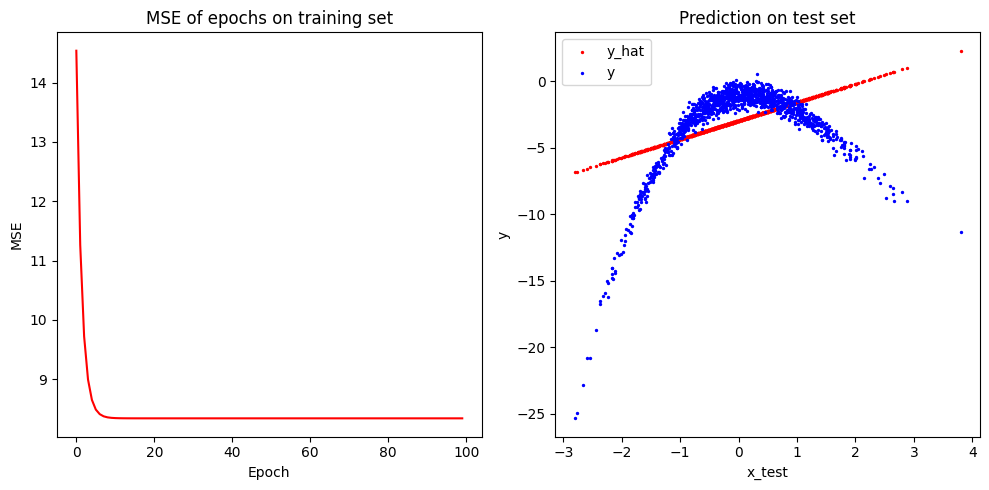

In [7]:
print("Training:")
learning_rate = train_neuron(algo=adaline_sgd, algo_predict_func=adaline_predict)

w, mse_scores = adaline_sgd(x_train, y_train, eta=learning_rate, max_epoch=100)
y_hat_test = [adaline_predict(x_i, w) for x_i in x_test]
print('w: ', w)
print("MSE on test data:", calc_mse(y_hat_test, y_test))

ploting_results(mse_scores, x_test, y_test, y_hat_test)

Comparision between Adaline batch mode and stochastic mode:
- Stochastic mode can approximate the batch mode. This is because the weights learned by two mode are very closed.
- However, there is a slight improvement Stochastic mode. The MSE in the Adaline SGD is slightly lower than batch mode (around 0.003)

Overall, because Adaline Neuron can learn linear function but it can not capture the true cubic function of the data. We may try to add the degree term to the input, which will allow the Adaline neuron to capture non-linear just like Polynomial Regression.

#### Adaline SGD with additional degree terms

In addition to the above experiments, we also tried to add degree terms and applied the Adaline Stochastic Mode. 

On train set, by utilizing cross validation, d = 3 yields the best average MSE.

In [8]:
degrees = range(2, 6)
avg_mse_scores = [] # store the average of MSE on test fold of each degree
def add_degree(x, d):
    x_1 = x[:,1]
    new_data = np.ndarray(shape=(x.shape[0], d + 1))
    for i in range(d + 1):
        new_data[:,i] =  x_1 ** i
    return new_data

for d in degrees:
    mse_scores = [] # store MSE on test folds
    for train_fold, test_fold in kf.split(x_train):
        w, _ = adaline_sgd(add_degree(x_train[train_fold], d), y_train[train_fold], 10**(-2*d), max_epoch=500)
        y_hat = [adaline_predict(x_i, w) for x_i in add_degree(x_train[test_fold], d)]
        mse_scores.append(calc_mse(y_hat, y_train[test_fold]))
    print(f"D={d}, Average MSE = {np.mean(mse_scores)}")
    avg_mse_scores.append(np.mean(mse_scores))

best_d = degrees[np.argmin(avg_mse_scores)]
print(f'Best degree: {degrees[np.argmin(avg_mse_scores)]}')

D=2, Average MSE = 0.7158520582803445
D=3, Average MSE = 0.2742465447303114
D=4, Average MSE = 8.22743723483654
D=5, Average MSE = 60.887338495216554
Best degree: 3


On test set, d=3 provides the best MSE. The weight learned on train data  is $w=[-1.0393, 0.3610, -1.9832, 0.3305]$ which is very closed to the $w_{true} = (-1, +0.5, -2, +0.3). $

D = 2, w=[-0.98088126  1.365402   -2.02819322]. Test set MSE = 0.7285903724546638
D = 3, w=[-0.84484928  0.372851   -2.06764192  0.32708007]. Test set MSE = 0.2651391259718624
D = 4, w=[ 0.11108188 -0.2076465  -0.23069761 -0.00101903 -0.30084955]. Test set MSE = 10.421183058158713
D = 5, w=[ 0.29452431  0.1582107  -0.17725251 -0.38073683 -0.04708071  0.20183671]. Test set MSE = 31.456878897656896


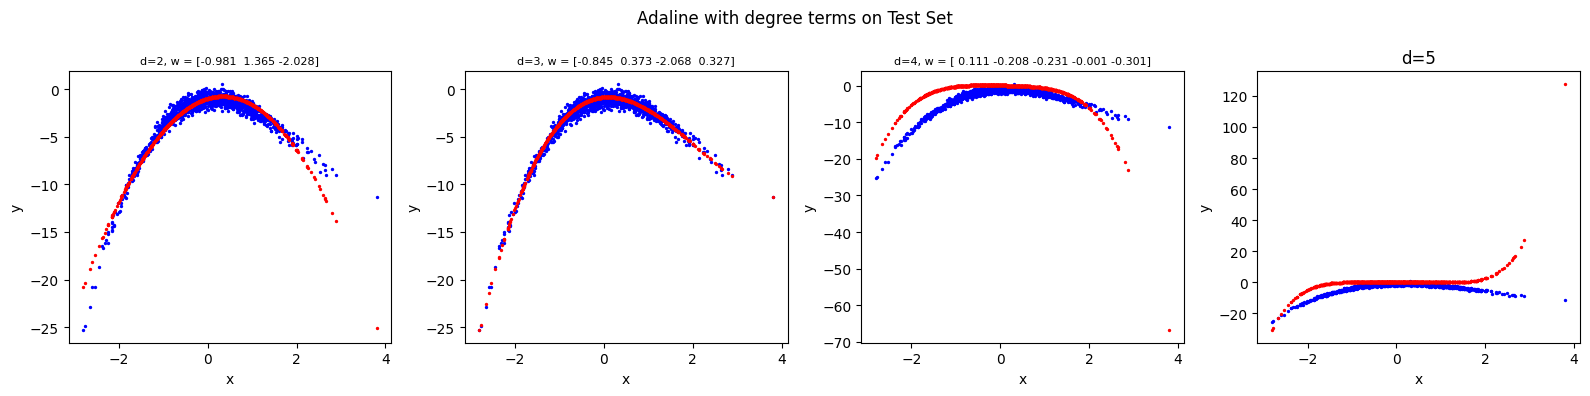

In [9]:
# Creating subplots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs = axs.flatten()
mse_scores = []
for d in degrees:
    x_train_transformed = add_degree(x_train, d)
    x_test_transformed = add_degree(x_test, d)
    w, _ = adaline_sgd(x_train_transformed, y_train, 10**(-2*d), max_epoch=500)
    
    y_hat = [adaline_predict(x_i, w) for x_i in x_test_transformed]
    
    mse_scores.append(calc_mse(y_hat, y_test))
    print(f"D = {d}, w={w}. Test set MSE = {calc_mse(y_hat, y_test)}")
    # Plot the prediction.
    axs[d - 2].scatter(x_test[:, 1], y_test, s=2, color='blue', label='y')
    axs[d - 2].scatter(x_test[:, 1], y_hat, s=2, color='red', label='Predicted y_hat')
    axs[d - 2].set_xlabel('x')
    axs[d - 2].set_ylabel('y')
    if (d <= 4):  axs[d - 2].set_title(f'd={d}, w = {np.round(w, 3)}', fontsize=8)
    else: axs[d - 2].set_title(f'd={d}')
    
fig.suptitle('Adaline with degree terms on Test Set')
plt.tight_layout()
plt.show()

### 1.2.2 Sigmoid Neuron Algorithm
- The `sigmoid_bgd` function is implemented based on the code of the batch mode and sigmoid activation function in lecture slide.
- The `sigmoid_sgd` function is implemented based on the code of the stochastic mode and sigmoid activation function in lecture slide.
- The `sigmoid_predict` function return the prediction of the Sigmoid Neuron using the formula $\hat{y} = \phi(v) = \frac{1}{1 + e^{-v}}$ where $v = w^{T}x$

In [10]:
np.random.seed(0)

def sigmoid_predict(x, w):
    v = w.T.dot(x)
    return 1 / (1 + np.exp(-v))

def sigmoid_bgd(X, y, eta=0.005, max_epoch=100):
    """
    Sigmoid Batch gradient descent
    Return 
    - w: learned w
    - mse_scores: mse of every epoch
    """
    w = np.random.random(X.shape[1]) * -1 + 0.5 # weights initialization in range [-0.5, 0.5]
    mse_scores = []

    for _ in range(max_epoch):
        d_w = np.zeros(X.shape[1])
        for x_i, y_i in zip(X, y):
            y_hat_i = 1 / (1 + np.exp(-w.T.dot(x_i)))
            d_w += eta * (y_i - y_hat_i) * y_hat_i * (1 - y_hat_i) * x_i

        w = w + d_w
        mse_scores.append(calc_mse([sigmoid_predict(x_i, w) for x_i in X], y))
    return w, mse_scores

def sigmoid_sgd(X, y, eta=0.005, max_epoch=100):
    """
    Adaline Sochastic gradient descent
    Return 
    - w: learned w
    - mse_scores: mse of every epoch
    """
    
    w = np.random.random(X.shape[1]) * -1 + 0.5 # weights initialization in range
    mse_scores = []

    for _ in range(max_epoch):
        for x_i, y_i in zip(X, y): # iteration through all sample 
            y_hat_i = 1 / (1 + np.exp(-w.T.dot(x_i)) ) # predict output
            w += eta * (y_i - y_hat_i) * y_hat_i * (1 - y_hat_i) * x_i # compute the gradient of one sample
            
        
        mse_scores.append(calc_mse([sigmoid_predict(x_i, w) for x_i in X], y))
    return w, mse_scores

#### Sigmoid - Batch mode

Using the same fashion, we also selected a learning rate of 0.001 after cross validation. On train data, the MSE was minimized as the Sigmoid BGD executed on more epoches.

After 100 epoches, the resulted w is $[-4.6140, 0.2307]$ and the MSE on test data is 17.1712

Training:
eta= 0.001, average MSE: 19.163873446029385
eta= 0.0001, average MSE: 19.220812962762153
eta= 1e-05, average MSE: 19.93458100655654
eta= 1e-06, average MSE: 21.59451793472315
eta= 1e-07, average MSE: 22.4517832157545
eta= 1e-08, average MSE: 22.29549227214774
eta= 1e-09, average MSE: 22.30283722563628
eta= 1e-10, average MSE: 22.635600991494854
Best learning rate:  0.001
w:  [-4.61402848  0.23065088]
MSE on test data: 17.17122766254396


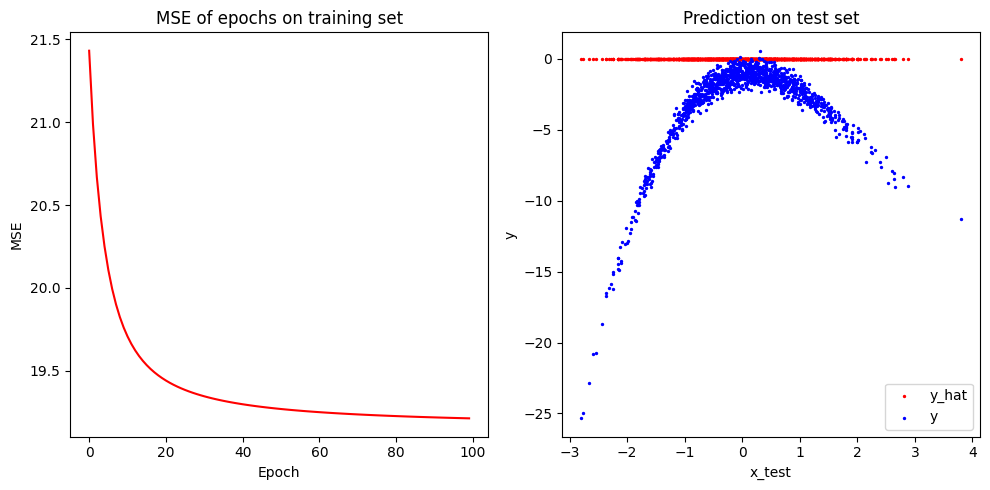

In [11]:
print("Training:")
learning_rate = train_neuron(algo=sigmoid_bgd, algo_predict_func=sigmoid_predict)

w, mse_scores = sigmoid_bgd(x_train, y_train, eta=0.0001, max_epoch=100)
y_hat_test = [sigmoid_predict(x_i, w) for x_i in x_test]
print('w: ', w)
print("MSE on test data:", calc_mse(y_hat_test, y_test))

ploting_results(mse_scores, x_test, y_test, y_hat_test)

If we take a closer look to Sigmoid BGD prediction, we can observed that the function learned is actually not linear when we plotted it separately.

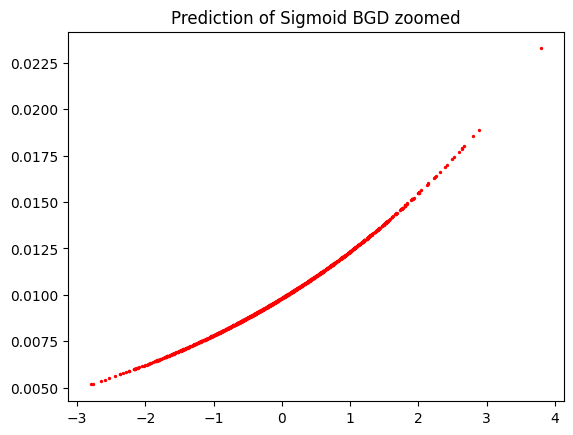

In [12]:
plt.scatter(x_test[:,1], y_hat_test, color='red', label="y_hat", s=2)
plt.title("Prediction of Sigmoid BGD zoomed")
plt.show()

#### Sigmoid - Stochastic mode

We also selected a learning rate of 0.001 after cross validation because of lowest average MSE across all folds. On train data, the MSE was minimized as the Sigmoid BGD executed on more epoches.

After 100 epoches, the resulted w is $[-6.9543, 0.2235]$ and and the MSE on test data is 17.1220

Training:
eta= 0.001, average MSE: 19.164093411631914
eta= 0.0001, average MSE: 19.22199184803533
eta= 1e-05, average MSE: 19.941668253102005
eta= 1e-06, average MSE: 21.945868366601193
eta= 1e-07, average MSE: 22.204923649419587
eta= 1e-08, average MSE: 22.673376034717208
eta= 1e-09, average MSE: 22.179947608513153
eta= 1e-10, average MSE: 22.245257880670614
Best learning rate:  0.001
w:  [-6.95431164  0.22347251]
MSE on test data: 17.121995221212487


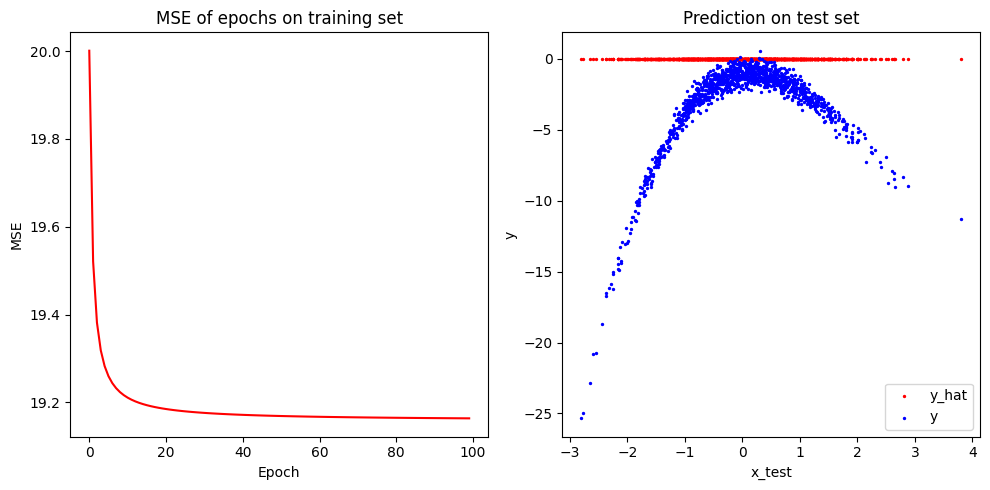

In [13]:
print("Training:")
learning_rate = train_neuron(algo=sigmoid_sgd, algo_predict_func=sigmoid_predict)

w, mse_scores = sigmoid_sgd(x_train, y_train, eta=learning_rate, max_epoch=100)
y_hat_test = [sigmoid_predict(x_i, w) for x_i in x_test]
print('w: ', w)
print("MSE on test data:", calc_mse(y_hat_test, y_test))

ploting_results(mse_scores, x_test, y_test, y_hat_test)


If we take a closer look to Sigmoid SGD prediction, we can observed that the function learned is actually not linear when we plotted it separately.

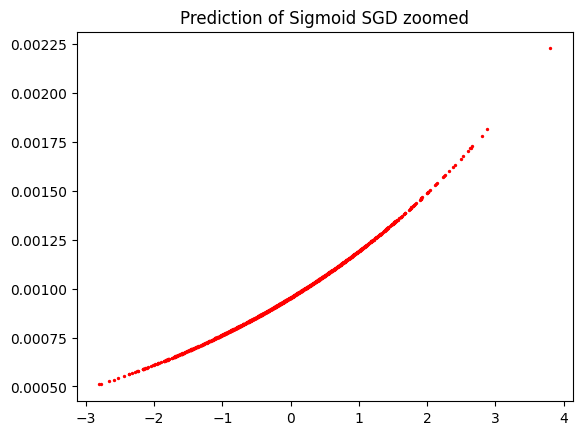

In [14]:
plt.scatter(x_test[:,1], y_hat_test, color='red', label="y_hat", s=2)
plt.title("Prediction of Sigmoid SGD zoomed")
plt.show()

Comparision between Sigmoid batch mode and stochastic mode:
- The learned weights are different between Stochastic mode and Batch mode
- However, there is much improvement Stochastic mode. The MSE in the Sigmoid SGD is lower than Batch mode (around 0.05)

Overall, Sigmoid Neuron can learn non-linear function, however, the perfomance of Sigmoid neuron is worse than linear function learned by Adaline for both Batch Gradient Descent or Stochastic Gradient Descent mode. This is because Sigmoid activation function always predict the output lies in the range $[0,1]$, which is not the case for our dataset because $y$ has larger range.

# Question 2

In this question you are to create some simulated data sets and then use the Perceptron neuron to perform some classification.

## a. Randomly create 2500 data-points (x, y)’s of class -1 to lie one side of the function f above and 2500 data-points (x, y)’s of class +1 to lie on the other side of the function. Indeed, here, you are not required to create your data using the function f above; you can use any function you want, as long as it is a simple linearly separable function of your choice to be used to separate 5000 data points into two classes (I have mentioned the function above simply because you have it already).

We use the function $f = -5 + 5x$ as the linear functions and generate 2500 points of -1 class and 2500 points of +1 class

plus_1's shape:  (2500, 2)
minus_1's shape:  (2500, 2)


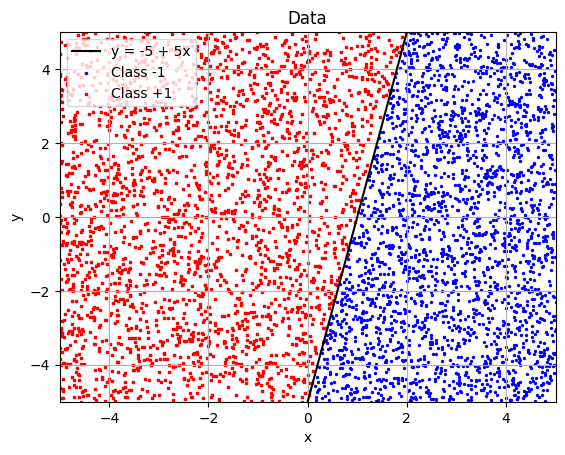

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from sklearn.model_selection import KFold, train_test_split

plus_1 = []
minus_1 = []
slope = 5
intercept = -5
np.random.seed(0)

#We will be using y = ax + b as our f function
for i in range(100000):
    x = np.random.uniform(-5, 5)
    y = np.random.uniform(-5, 5)

    num = slope * x + intercept
    if y < num:
        if len(minus_1) < 2500:
            minus_1.append((x, y))
    elif y >= num:
        if len(plus_1) < 2500:
            plus_1.append((x, y))

plus_1 = np.array(plus_1)
minus_1 = np.array(minus_1)

# print("plus_1: ", plus_1)
print("plus_1's shape: ", plus_1.shape)
# print("minus_1: ", minus_1)
print("minus_1's shape: ", minus_1.shape)
# Plot the function f

X = np.concatenate([plus_1, minus_1], axis=0)
y = np.concatenate([np.ones(2500), -np.ones(2500)], axis=0)

plt.plot(np.linspace(-5, 5, 100), slope * np.linspace(-5, 5, 100) + intercept, c='black', label=f'y = {intercept} + {slope}x')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='blue', marker='o', label='Class -1', s=2)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='red', marker='s', label='Class +1', s=2)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title('Data')
plt.legend()
# Show the plot
plt.grid(True)
plt.show()

## b. Implement the Perceptron learning algorithm and run it on your synthetic data set. Obtain the best Perceptron model via any cross-validation method of your choice. Use your creativity to tell me anything about your Perceptron: for example, how does the performance (speed and accuracy) vary when changing the learning rate, or when varying the size of the size of the training and test sets?

The following Perceptron implementation was done by following these tutorials: 
- https://www.youtube.com/watch?v=t2ym2a3pb_Y&t=304s
- https://www.youtube.com/watch?v=aOEoxyA4uXU

In [ ]:
class Perceptron:
    def __init__(self, learning_rate=0.1, max_iterates=10000):
        self.learning_rate = learning_rate
        self.max_iterates = max_iterates
        self.activation_func = self.sign
        self.weight = None
        self.bias = None

    def fit(self, X, y):
        samples, features = np.shape(X)
        self.weight = np.zeros(features)
        self.bias = 0
        i = 0
        while True:
            error = 0

            for index, x_i in enumerate(X):
                output = np.dot(x_i, self.weight) + self.bias
                Y_predicted = self.activation_func(output)
                
                if y[index] != Y_predicted:
                    error += 1
                
                update = self.learning_rate * (y[index] - Y_predicted)
                self.weight += update * np.array(x_i)
                self.bias += update
            
            if error == 0 or i > self.max_iterates: 
                break
            i += 1

            

    def predict(self, X):
        output = np.dot(X, self.weight) + self.bias
        Y_predicted = self.activation_func(output)
        return Y_predicted
    
    def sign(self, x):
        return np.where(x > 0, 1, -1)

To obtain the best model and experiment with different test set size, learning rates, we defined the following function `evaluate_model` which performs the following steps:
- Split the data into training data, and test data with the input `test_size`
- On train data, we use 10-folds cross validation to find the best learning rate in the list of `learning_rates`. We print out the time taken to train and also average accuracy.
- On test data, with the learning rate selected, we calculate the accuracy, and confusion matrix on test set. In addition, we also plot the decision boundary found by the learning algorithm to compare it with the true function $f= -5 + 5x$



In [ ]:
def evaluate_model(Model, learning_rates, test_size):
    """
    Model: Perceptron or Pocket
    """
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=test_size)
    kf = KFold(n_splits=10, shuffle=True, random_state=0)

    ## STEP: 1 Cross validation on Train data to find best learning rate 
    print(f"=== Cross validation (10-fold) on Training data ====")
    for i in learning_rates:
        total = 0
        acc_scores = [] # store MSE on test folds
        for train_fold, test_fold in kf.split(x_train):
            model = Model(learning_rate=i, max_iterates=500)
            start = time.time()
            model.fit(x_train[train_fold], y_train[train_fold])
            end = time.time()
            prediction = model.predict(x_train[test_fold])
            total += (end - start)
            acc_scores.append(accuracy_score(prediction, y_train[test_fold]))

        print(f'Learning rate: {i}, Training time: {total}. Average accuracy = {np.mean(acc_scores)}')

   
    best_learning = learning_rates[np.argmax(acc_scores)]
    print(f"Best Learning Rate: {best_learning}")
    model = Model(learning_rate=i, max_iterates=500)
    model.fit(x_train, y_train)

    ## STEP 2: Evaluation on Testset
    print(f"=== Performance on Testset ===")
    prediction = model.predict(x_test)
    accuracy = accuracy_score(y_test, prediction)
    print("Testset Accuracy: ", accuracy)

    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, prediction))

    # 3. Plot decision boundary on test set
    x_range = y_range = (-6, 6)
    xx, yy = np.meshgrid(*[np.linspace(*r, 600) for r in [x_range, y_range]])
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='bwr')
    plt.scatter(x_test[y_test == -1][:, 0], x_test[y_test == -1][:, 1], c='blue', marker='o', label='Class -1', s=2)
    plt.scatter(x_test[y_test == 1][:, 0], x_test[y_test == 1][:, 1], c='red', marker='s', label='Class +1', s=2)
    plt.plot(np.linspace(*x_range, 100), slope * np.linspace(*x_range, 100) + intercept, c='black', label=f'y = {intercept} + {slope}x')
    plt.legend()
    plt.xlim(*x_range)
    plt.ylim(*y_range)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary on Test set')
    plt.show()

With the 25% of the data for testing and we used different learning rates
- We didn't observed much different in terms of average accuracy.
- There are a slight difference in training time. If the learning rate is small (0.001, 0.05) or large (0.5, 0.9), the trainning duration is longer. The one in the middle (learning rate = 0.01) has the shortest training time 
- On test data, only one sample was misclassified. We're able to get the accuracy of 99.92% and the decision boundary is almost the same as the true function 

=== Cross validation (10-fold) on Training data ====
Learning rate: 0.001, Training time: 4.081516981124878. Average accuracy = 0.9997333333333334
Learning rate: 0.01, Training time: 4.074813604354858. Average accuracy = 0.9997333333333334
Learning rate: 0.05, Training time: 3.9400644302368164. Average accuracy = 0.9997333333333334
Learning rate: 0.1, Training time: 4.0174946784973145. Average accuracy = 0.9997333333333334
Learning rate: 0.5, Training time: 4.1124913692474365. Average accuracy = 0.9997333333333334
Learning rate: 0.9, Training time: 4.013890743255615. Average accuracy = 0.9997333333333334
Best Learning Rate: 0.001
=== Performance on Testset ===
Testset Accuracy:  0.9992
Confusion Matrix: 
[[653   1]
 [  0 596]]


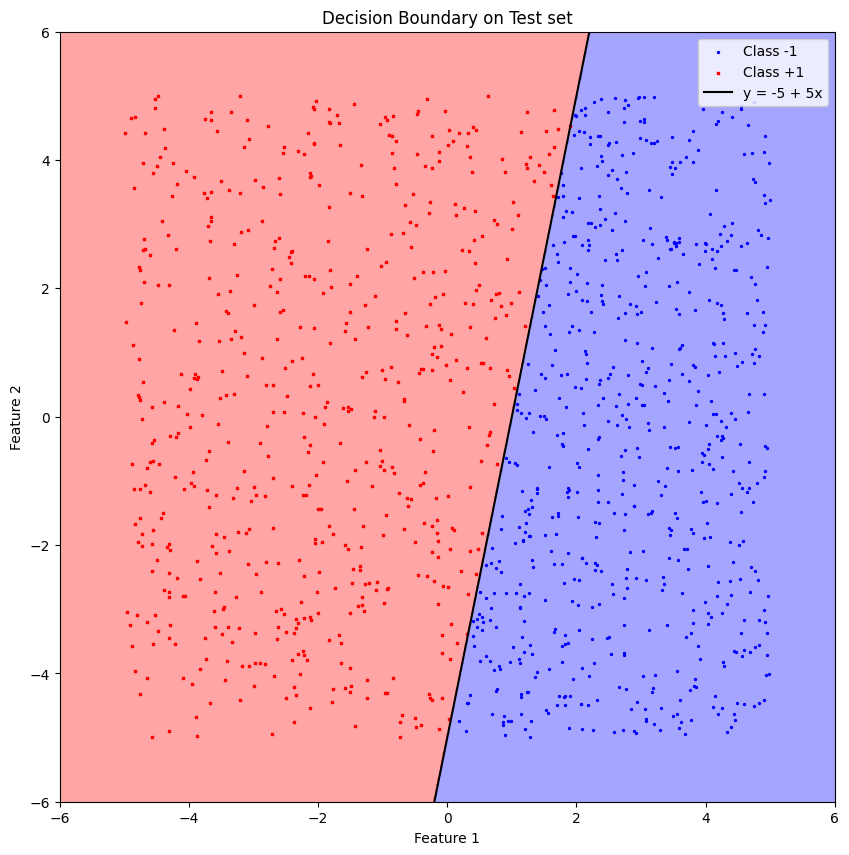

In [ ]:
evaluate_model(Perceptron, learning_rates=[0.001, 0.01, 0.05, 0.1, 0.5, 0.9], test_size=0.25)

With the 75% of the data for testing and we used different learning rates, we observed that
- On train dataset: 
    - With smaller data for training (25%), the Perceptron run faster because there are less data for training. 
    - We didn't observed much different in terms of average accuracy with different learning rates. However, in comparision the 25% test_size, the average accuracy on train data is better with 100%.
- On test dataset, however, the accuracy on test set is worse with 6 data points were missclassified. In the decision boundary plot, we can see that the decision boundary is quite different than the true function f.

=== Cross validation (10-fold) on Training data ====
Learning rate: 0.001, Training time: 1.6872472763061523. Average accuracy = 1.0
Learning rate: 0.01, Training time: 1.6182546615600586. Average accuracy = 1.0
Learning rate: 0.05, Training time: 1.6369671821594238. Average accuracy = 1.0
Learning rate: 0.1, Training time: 1.647636890411377. Average accuracy = 1.0
Learning rate: 0.5, Training time: 1.62050461769104. Average accuracy = 1.0
Learning rate: 0.9, Training time: 1.6205780506134033. Average accuracy = 1.0
Best Learning Rate: 0.001
=== Performance on Testset ===
Testset Accuracy:  0.9984
Confusion Matrix: 
[[1863    1]
 [   5 1881]]


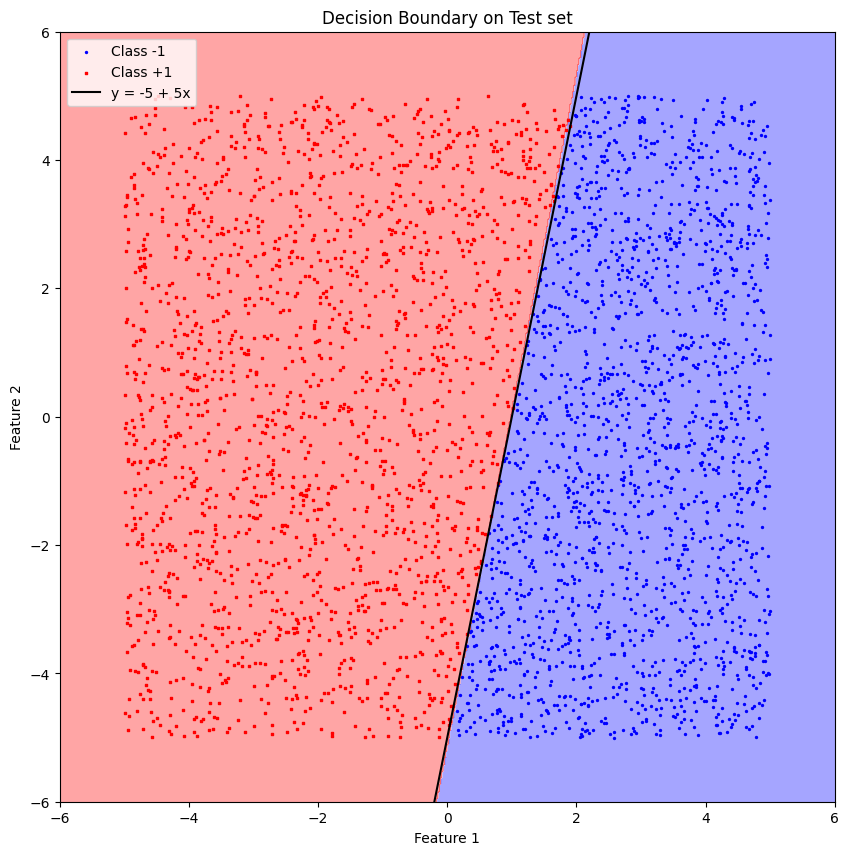

In [ ]:
evaluate_model(Perceptron, learning_rates=[0.001, 0.01, 0.05, 0.1, 0.5, 0.9],  test_size=0.75)

## c. Repeat the task above but replace the Perceptron learning algorithm with any one of its variants mentioned in Slide-23 of the Single Neuron chapter, that is: pocket algorithm, the max-over learning algorithm, the algorithm, the voted perceptron algorithm,  min-over learning algorithm, AdaTron learning algorithm, or the α-perceptron learning algorithm. Implement only one of these variants; they are not discussed in class, though you can find them online via Google search (eg, https://www.google.com/search?client=safari&rls=en&q=Pocket+algorithm&ie=UTF-8&oe=UTF-8).

The Pocket algorithm only keeps the best weight in it "pocket". We re-used the Perceptron class for this, but modified the fit method so that the weight of Pocket will only be updated with the better error.

In [ ]:
class Pocket(Perceptron):
    def fit(self, X, y):
        samples, features = np.shape(X)
        self.weight = np.zeros(features)
        self.bias = 0
        
        curr_weight = np.zeros(features)
        curr_bias = 0
        
        i = 0
        best_error = np.inf
        while True:
            error = 0

            for index, x_i in enumerate(X):
                output = np.dot(x_i, self.weight) + self.bias
                Y_predicted = self.activation_func(output)
                if (Y_predicted != y[index]): error += 1
                
                update = self.learning_rate * (y[index] - Y_predicted)
                curr_weight += update * np.array(x_i)
                curr_bias += update
            
            # the pocket algorithm keeps the best weight only 
            # therefore we only change pocket weight if error is smaller.
            if error < best_error:
                self.weight = curr_weight
                self.bias = curr_bias
                best_error = error

            # stop when the algorithm converges
            if error == 0 or i > self.max_iterates: 
                break
            i += 1


With the 25% of the data for testing and we used different learning rates:
- On train data: We didn't observe the difference in terms of average accuracy with 10-fold cross validation with 99.97% accuracy.
- On test data: We are able to achieve 100% on test data with the Pocket algorithm which is better than Perceptron with one missclassified sample.

=== Cross validation (10-fold) on Training data ====
Learning rate: 0.001, Training time: 3.7632522583007812. Average accuracy = 0.9997333333333334
Learning rate: 0.01, Training time: 3.799438238143921. Average accuracy = 0.9997333333333334
Learning rate: 0.05, Training time: 3.7121527194976807. Average accuracy = 0.9997333333333334
Learning rate: 0.1, Training time: 3.837769031524658. Average accuracy = 0.9997333333333334
Learning rate: 0.5, Training time: 3.7970774173736572. Average accuracy = 0.9997333333333334
Learning rate: 0.9, Training time: 3.8507142066955566. Average accuracy = 0.9997333333333334
Best Learning Rate: 0.001
=== Performance on Testset ===
Testset Accuracy:  1.0
Confusion Matrix: 
[[654   0]
 [  0 596]]


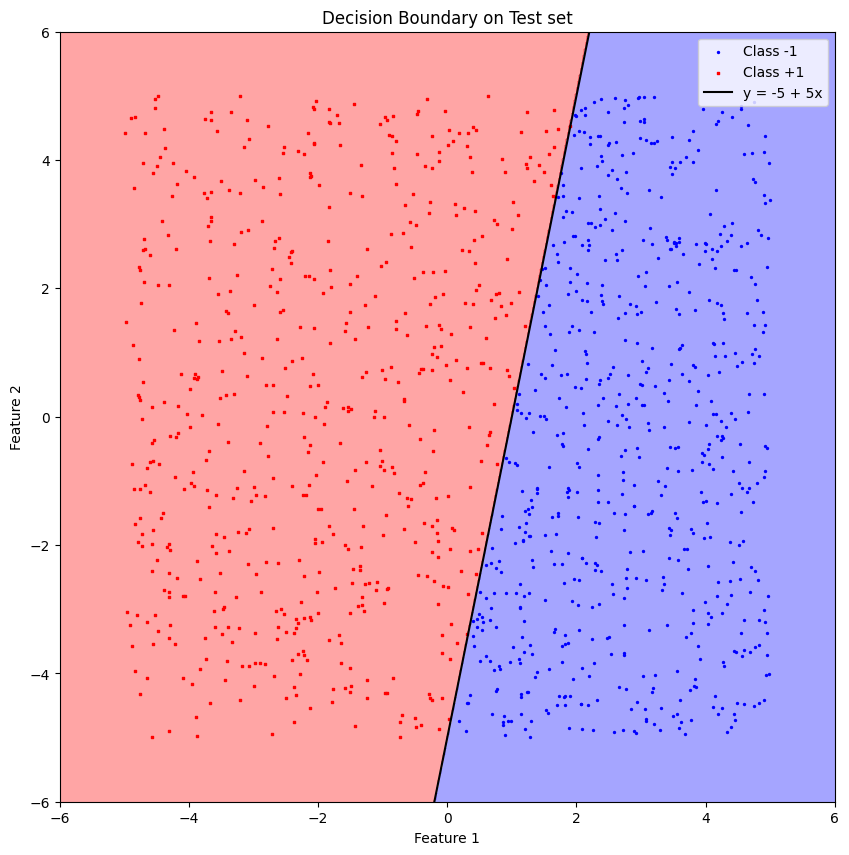

In [ ]:
evaluate_model(Pocket, learning_rates=[0.001, 0.01, 0.05, 0.1, 0.5, 0.9], test_size=0.25)

With the 75% of the data for testing and we used different learning rates, we observed that
- On train dataset: 
    - With smaller data for training (25%), the Pocket algorithm run faster because there are less data for training. 
    - We didn't observed much different in terms of average accuracy. The average accuracy on train data is 100%.
- On test dataset: however, the accuracy on test set is worse with 4 data points were missclassified. In the decision boundary plot, we can see that the decision boundary is slightly different than the true function f. Pocket algorithm performed better compared to Perceptron with 6 missclassfied samples.

=== Cross validation (10-fold) on Training data ====
Learning rate: 0.001, Training time: 1.1319432258605957. Average accuracy = 1.0
Learning rate: 0.01, Training time: 1.097330093383789. Average accuracy = 1.0
Learning rate: 0.05, Training time: 1.0636918544769287. Average accuracy = 1.0
Learning rate: 0.1, Training time: 1.1390047073364258. Average accuracy = 1.0
Learning rate: 0.5, Training time: 1.0710492134094238. Average accuracy = 1.0
Learning rate: 0.9, Training time: 1.0735588073730469. Average accuracy = 1.0
Best Learning Rate: 0.001
=== Performance on Testset ===
Testset Accuracy:  0.9989333333333333
Confusion Matrix: 
[[1864    0]
 [   4 1882]]


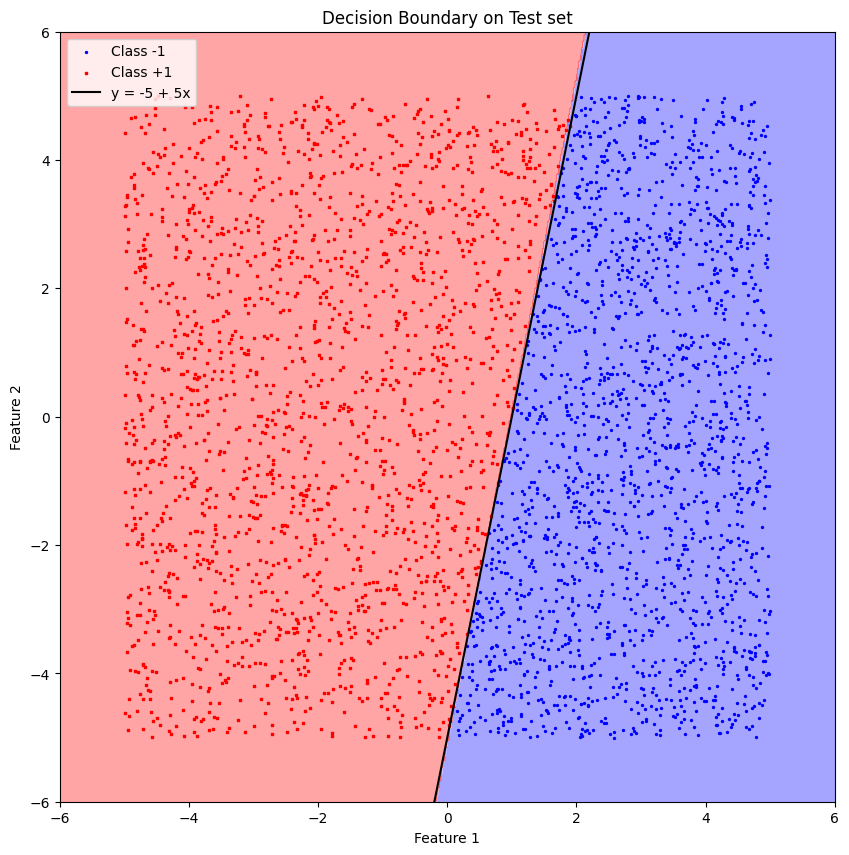

In [ ]:
evaluate_model(Pocket, learning_rates=[0.001, 0.01, 0.05, 0.1, 0.5, 0.9], test_size=0.75)

In [16]:
!jupyter nbconvert --output-dir './A1' 'A1 - Q1.ipynb' --to latex

[NbConvertApp] Converting notebook A1 - Q1.ipynb to latex
[NbConvertApp] Support files will be in A1 - Q1_files/
[NbConvertApp] Writing 103184 bytes to A1/A1 - Q1.tex
